In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))
models = torch.load('data_generated/week7/models.pth', map_location=device)

# Convert TempConvAE's weights
d = models['10-TempConvAE']['model']
d["to_lower_rep.weight"] = d["low_dim_mapping.0.weight"]
d["to_lower_rep.bias"] =   d["low_dim_mapping.0.bias"]
d["from_lower_rep.weight"] = d["low_dim_mapping.1.weight"]
d["from_lower_rep.bias"] = d["low_dim_mapping.1.bias"]
del d["low_dim_mapping.0.weight"]
del d["low_dim_mapping.0.bias"]
del d['low_dim_mapping.1.weight']
del d['low_dim_mapping.1.bias']
del models['10-OneHAE']['little_modification']

Device: Tesla P100-PCIE-12GB


In [2]:
i2task = {0: 'Knot_Tying',
        1: 'Needle_Passing',
        2: 'Suturing'}
ntask = len(i2task.keys())
task2i = {v: k for k, v in i2task.items()}

# Gesture index to description
gi2descr = {
    1: 'Reaching for needle with right hand',
    2: 'Positioning needle',
    3: 'Pushing needle through tissue',
    4: 'Transferring needle from left to right',
    5: 'Moving to center with needle in grip',
    6: 'Pulling suture with left hand',
    7: 'Pulling suture with right hand',
    8: 'Orienting needle',
    9: 'Using right hand to help tighten suture',
    10: 'Loosening more suture',
    11: 'Dropping suture at end and moving to end points',
    12: 'Reaching for needle with left hand',
    13: 'Making C loop around right hand',
    14: 'Reaching for suture with right hand',
    15: 'Pulling suture with both hands'
}

def load_video_data(tasks=None, subjects=None, trials=None, captures=None, gestures=None):
    if tasks is None:
        tasks = np.array(list(task2i.values()))
    else:
        tasks = np.array(tasks).ravel()

    root_path = 'data/JIGSAWS_converted'
    #or_tasks = '\|'.join([i2task[task] for task in tasks])
    video_meta = !find $root_path -name '*.avi' | sed 's:^.*/\([^/]\+_[A-Z][0-9]\{3\}\)_.*$:\1:'
    video_meta = [name[-4:] for name in video_meta for task in tasks if i2task[task] in name]
    if subjects is None:
        subjects = np.unique([x[0] for x in video_meta])
    else:
        subjects = np.array(subjects).ravel()

    if trials is None:
        trials = np.unique([x[-1] for x in video_meta])
    else:
        trials = np.array(trials).ravel()

    if captures is None:
        captures = np.array([1,2])
    else:
        captures = np.array(captures).ravel()

    if gestures is None:
        gestures = np.array(list(gi2descr.keys()))
    else:
        gestures = np.array(gestures).ravel()

    X = []
    y = []
    for task in tasks:
        task_name = i2task[task]
        for subject in subjects:
            for trial in trials:
                transcr_filename = f'{root_path}/{task_name}/transcriptions/{task_name}_{subject}00{trial}.txt'
                try:
                    with open(transcr_filename, 'r') as fp:
                        for l in fp.readlines():
                            start_frame, end_frame, gesture = l.split()
                            start_frame = int(start_frame)
                            end_frame = int(end_frame)
                            gesture = int(gesture[1:])
                            if not gesture in gestures:
                                continue
                            for capt in [1,2]:
                                video_filename = f'{root_path}/{task_name}/video/{task_name}_{subject}00{trial}_capture{capt}.avi'
                                fragment = VideoLoader(video_filename, gray=True, start_frame=start_frame,
                                                       duration_frames=end_frame-start_frame+1)
                                fragment.trial = trial
                                fragment.jig_capture = capt
                                fragment.subject = subject
                                fragment.task = task

                                X.append(fragment)
                                y.append(gesture)
                except FileNotFoundError:
                    print(f'Video not present: task {task_name}, subject {subject}, trial {trial}, capture {capt}')
                    break
    y = np.array(y)
    return X, y

## Classification procedure for participant B, Suturing task

In [3]:
ncomp = 10
task = 2
subject = 'B'

In [11]:
def evaluate_model(model, X, y, nsplits=5, X_transform=None):
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(X, y, groups):
        if X_transform is not None:
            X_train = X_transform(full_martin_gram[train_index, :][:, train_index])
            X_test = X_transform(full_martin_gram[test_index, :][:, train_index])
        else:
            X_train = full_martin_gram[train_index, :][:, train_index]
            X_test = full_martin_gram[test_index, :][:, train_index]

        # Predict
        model.fit(X_train, y[train_index])
        preds = model.predict(X_test)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        if cm.shape != (ngestures,ngestures):
            missing_gestures = set(gestures) - set(preds) - set(y[test_index])
            l = cm.shape[0]
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, np.zeros(l), axis=1)
                cm = np.insert(cm, gi, np.zeros(l+1), axis=0)
                cm[gi,gi] = 1
                l = l+1

        confusion_matrix_cum += cm/nsplits
        accuracy_cum += np.sum(np.diag(confusion_matrix_cum))/

    return accuracy_cum/nsplits, confusion_matrix_cum

### Points creation for baseline

In [4]:
video_data, y = load_video_data(tasks=task, subjects=subject)
nsample = len(y)
gestures = np.unique(y)
ngestures = len(gestures)
g2i = {g: i for i, g in enumerate(gestures)}
X = []
for video in video_data:
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))

### Computation of all distances for baseline

In [6]:
full_martin_gram = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_martin_gram[i,j] = full_martin_gram[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            if martin_dist(mi, mj) < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_martin_gram[i,j] = martin_dist(mi, mj)
full_martin_gram[full_martin_gram < 0] = 0

#### KNN

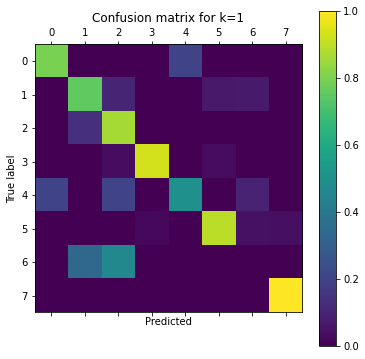

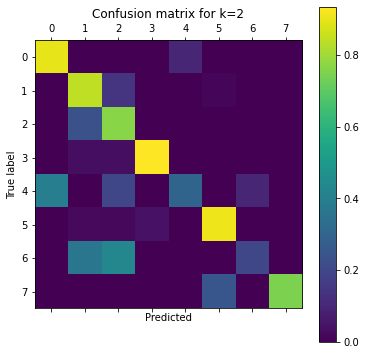

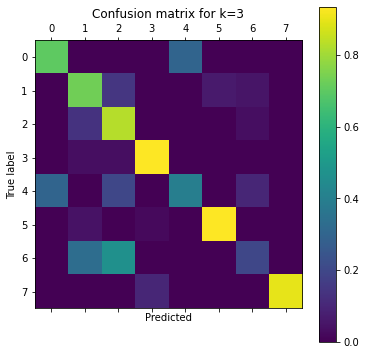

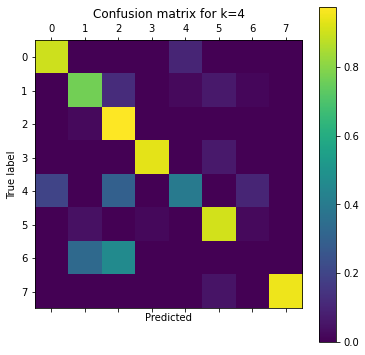

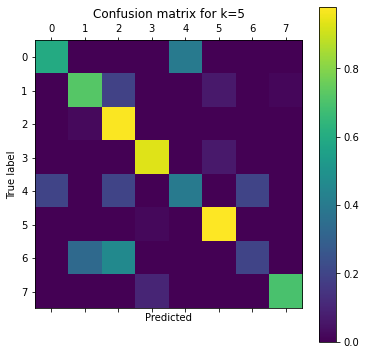

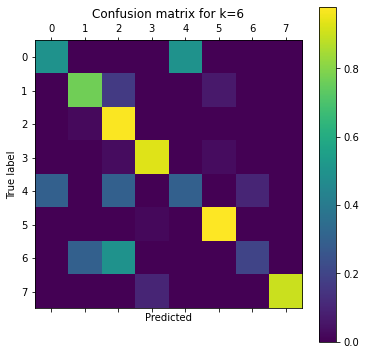

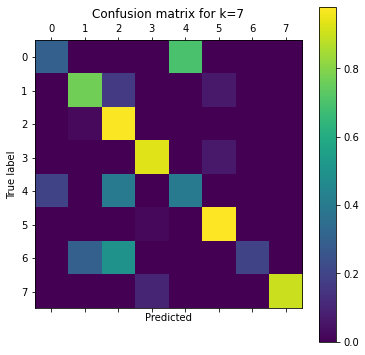

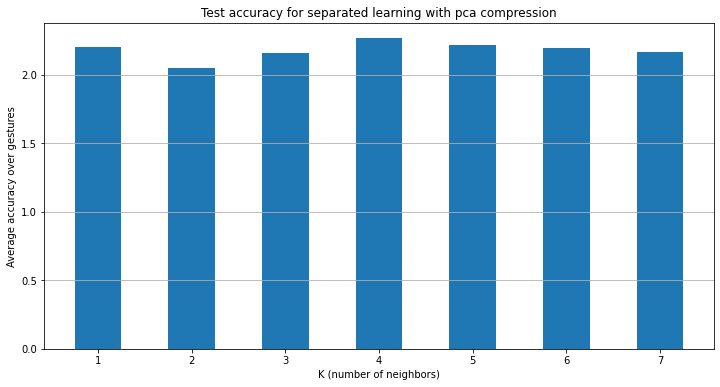

In [13]:
ks = np.arange(1, 8)
confusions_baseline_knn = np.zeros((len(ks), ngestures, ngestures))
accuracies_baseline_knn = np.zeros(len(ks))
for ki, k in enumerate(ks):
    nn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=4)
    accuracy, conf_matrix = evaluate_model(nn, X, y)
    accuracies_baseline_knn[ki] = accuracy
    confusions_baseline_knn[ki] = conf_matrix

for ki, k in enumerate(ks):
    matfig = plt.figure(figsize=(6,6))
    plt.matshow(confusions_baseline_knn[ki], fignum=matfig.number)
    plt.colorbar()
    plt.title(f'Confusion matrix for k={k}')
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

plt.figure(figsize=(12, 6))
plt.title('Test accuracy for separated learning with pca compression')
plt.bar(ks, accuracies_baseline_knn, width=0.5)
plt.ylabel('Average accuracy over gestures')
plt.xlabel('K (number of neighbors)')
plt.grid(axis='y')

#### SVM

In [ ]:
svm_model = SVC()
for gamma in np.logscale(-5, 5, 2)
    evaluate_model(svm_model, X_transform=lambda x: np.exp(-gamma*x))
    confusion_baseline_svm, accuracy =